A pesar de los esfuerzos de los gobiernos por implementar medidas estrictas de mitigación y/o supresión, el COVID-19 ha tenido un impacto profundo en los perfiles de demanda eléctrica en todo el mundo. Entre marzo, abril y mayo de 2020, la demanda eléctrica mundial se desplomó en todo el planeta, y países como España e Italia experimentaron una disminución de más del 20% en su consumo eléctrico habitual. Como consecuencia de estos cambios masivos en la demanda eléctrica, y a pesar del esfuerzo de los  sistemas de pronóstico por proporcionar una predicción precisa de la demanda, los operadores de las redes eléctricas se enfrentan a retos importantes para programar los recursos energéticos e infrestructura necesaria. 

En este ejercicio, haremos un pronóstico multivariado a múltiples pasos utilizando una red recurrente LSTM apilada. Se utilizará transfer learning para reusar el modelo construído con datos anteriores a la pandemia para obtener un modelo para el período de pandemia.

Los datos incluyen demanda mensual, observaciones meteorológicas y pronósticos  meteorológicos. Estos datos fueron obtenidos de proveedores de servicios meteorológicos y de servicios públicos reales y, por lo tanto, pueden estar contaminados con períodos perdidos, anomalías, etc. La fuente de la información es confidencial pero fue utilizada para el [concurso de pronóstico de demanda eléctrica al día siguiente de la IEEE](https://dx.doi.org/10.21227/67vy-bs34.s ).


# Pronóstico multivariado a múltiples pasos con redes LSTM

In [ ]:
# Redes neuronales
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Utilidades numéricas
import numpy as np
import pandas as pd

# Graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades - aprendizaje automático
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Utilidades - barras de carga
from tqdm.auto import tqdm

## Cargar datos, Preprocesamiento e Ingeniería de características

In [ ]:
# montamos la unidad de drive en colab
from google.colab import drive
drive.mount('/content/gdrive')

data_path='gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/Actuals.csv'

Mounted at /content/gdrive


In [ ]:
# Leer datos
df = pd.read_csv(data_path, decimal=',')

# Convertir a tipo de dato de fecha
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

# Convertir a valores numéricos
dtypes = {col:'float' for col in df.columns[1:]}
df = df.astype(dtypes)

Extraer información de día de la semana, mes y hora a partir de la fecha

In [ ]:
df['day_of_week'] = df.Time.dt.dayofweek
df['month'] = df.Time.dt.month
df['hour'] = df.Time.dt.hour

Codificar la ciclicidad de la dirección del viento

In [ ]:
df['wind_dir_sin'] = np.sin(df['Wind Direction (deg)'] * np.pi / 180.)
df['wind_dir_cos'] = np.cos(df['Wind Direction (deg)'] * np.pi / 180.)

Preprocesamiento general

In [ ]:
# Indexar por fecha
df.set_index('Time', inplace=True)

# Renombrar columnas
rename_cols = {
  'Load (kW)': 'load',
  'Pressure_kpa': 'pressure',
  'Cloud Cover (%)': 'cloud_cover',
  'Humidity (%)': 'humidity',
  'Temperature (C) ': 'temperature',
  'Wind Speed (kmh)': 'wind_speed',
}

df.rename(columns=rename_cols, inplace=True)

cols = [
  'load',
  'pressure',
  'cloud_cover',
  'humidity',
  'temperature',
  'wind_speed',
  'day_of_week',
  'month',
  'hour',
  'wind_dir_sin',
  'wind_dir_cos'
]

df = df[cols]

In [ ]:
df

,load,pressure,cloud_cover,humidity,temperature,wind_speed,day_of_week,month,hour,wind_dir_sin,wind_dir_cos
Time,,,,,,,,,,,
2017-03-18 00:00:00,1.031472e+06,1012.48000,2.125,79.333333,16.764386,6.253750,5,3,0,-0.964787,0.263031
2017-03-18 01:00:00,1.007206e+06,1011.61875,0.000,82.166667,15.729386,9.205000,5,3,1,-0.965926,0.258819
2017-03-18 02:00:00,9.861084e+05,1010.72000,2.125,81.666667,15.816886,11.283750,5,3,2,-0.694658,0.719340
2017-03-18 03:00:00,9.707610e+05,1011.37625,17.125,82.250000,15.919386,7.168750,5,3,3,-0.544639,0.838671
2017-03-18 04:00:00,9.622584e+05,1011.50000,18.625,82.333333,15.769386,0.780000,5,3,4,-0.977231,0.212178
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-06 11:00:00,1.242830e+06,1012.85000,45.625,68.166667,21.299386,8.280000,4,11,11,-0.418660,0.908143
2020-11-06 12:00:00,1.239480e+06,1011.75000,48.875,67.166667,22.419386,11.466250,4,11,12,-0.988362,-0.152123
2020-11-06 13:00:00,1.234773e+06,1010.93750,55.375,67.583333,22.971886,14.507500,4,11,13,-0.896873,0.442289


## Exploración de los datos

La variable de interés es `load` que corresponde al consumo energético.

Graficamos esta variable para observar qué patrones tiene.

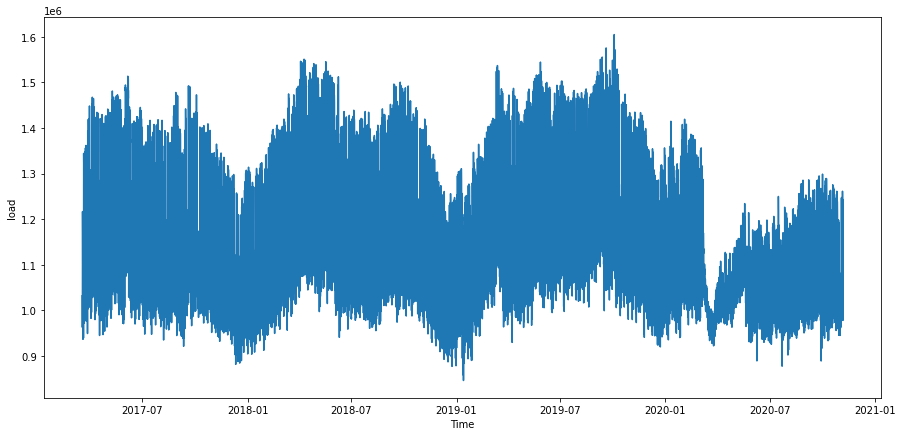

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df, y='load', x='Time')
plt.show()

Podemos observar un cambio drástico en el comportamiento de la serie al iniciar la cuarentena de COVID-19.

Analizaremos cada segmento de la serie por separado.

Entrenaremos un primer modelo predictivo para el comportamiento antes de la cuarentena. Posteriormente, usando transferencia de aprendizaje, partiremos de este primer modelo para hacer uno entrenado para predecir el energético durante la cuarentena.

In [ ]:
# Dividr datos antes y después del inicio de la cuarentena
# bc: before covid; ac: after covid
data_bc = df.loc[:'2020-03-7']
data_ac = df.loc['2020-03-7':]
print('Data before COVID-19:', len(data_bc), sep='\t')
print('Data after COVID-19:', len(data_ac), sep='\t')

Data before COVID-19:	26064
Data after COVID-19:	5872


## Predicción de consumo energético previo a la cuarentena

### Procesamiento de datos para entrenamiento

Dividimos los datos en dos conjuntos, entrenamiento y validación

In [ ]:
train_data, test_data = train_test_split(data_bc, train_size=0.8, shuffle=False)
print('Training data:', len(train_data), sep='\t\t')
print('Validation data:', len(test_data), sep='\t')

Training data:		20851
Validation data:	5213


Normalizamos los datos. Nótese que el normalizador se calcula con los datos de entrenamiento para evitar que se filtre información del conjunto de datos de validación al de entrenamiento.

In [ ]:
# Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))

# Obtener parámetros para normalizar de los datos de entrenamiento
train_data_normalized = scaler.fit_transform(train_data)

# Normalizar con los mismos parámetros a los datos de validación
test_data_normalized = scaler.transform(test_data)

Creamos una clase para cargar los datos al modelo

In [ ]:
class TimeseriesDataset(torch.utils.data.Dataset):
  """ Clase para crear conjuntos de datos para series de tiempo

      Dada una serie de tiempo (posiblemente multivariada),
      crea conjuntos de datos de entrada y salida según un tamaño de ventana
      y un horizonte de predicción
  """

  def __init__(self, X, y, window, horizon):
    self.X = X
    self.y = y
    self.window = window
    self.horizon = horizon

  def __len__(self):
    return self.X.__len__() - self.horizon - self.window

  def __getitem__(self, index):
    return (
      self.X[index:index + self.window],
      self.y[index + self.window: index + self.window + self.horizon]
    )

Creamos el cargador de datos

In [ ]:
# Valores previos para predicción: 1 semana de valores horarios
window = 24 * 7

# Horizonte de predicción: 1 día con valores horarios
horizon = 24

# Ejemplos a considerar por paso de entrenamiento
batch_size = 16

train_dataset = TimeseriesDataset(train_data_normalized, train_data_normalized[:, 0], window, horizon)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TimeseriesDataset(test_data_normalized, test_data_normalized[:, 0], window, horizon)
test_loader = torch.utils.data.DataLoader(test_dataset)

## Modelado

El modelo es una red neuronal recurrente compuesta por dos capas de unidades LSTM seguidas por una capa densa.

In [ ]:
class LSTM(nn.Module):
  def __init__(self, n_features, n_hidden, n_layers):
    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers

    # Capa LSTM
    self.l_lstm = nn.LSTM(input_size=n_features, 
                          hidden_size=self.n_hidden,
                          num_layers=self.n_layers, 
                          batch_first=True)
  
    # Capa Densa de activación lineal
    self.l_linear = nn.Linear(self.n_hidden * window, horizon)

    # Estado escondido
    self.hidden_cell = (torch.zeros(1,1,self.n_hidden),) * n_hidden

  def init_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    self.hidden = (hidden_state, cell_state)

  def forward(self, x):
    batch_size, seq_len, _ = x.size()
    lstm_out, self.hidden = self.l_lstm(x,self.hidden)
    x = lstm_out.contiguous().view(batch_size,-1)
    return self.l_linear(x)

Determinamos los hiperparámetros de la red.

A mayor número de capas (`n_layers`) la red tendrá capacidad de encontrar patrones de mayor abstracción.

A mayor cantidad de celdas ocultas (`n_hidden`) la red tendrá más capacidad para ajustarse a los datos.

Los mejores valores para cada hiperparámetro dependerán del problema. Para encontrar los óptimos se puede aplicar optimización de hiperparámetros.

In [ ]:
# Hiperparámetros de la red
n_features = len(cols)
n_hidden = 200
n_layers = 2

Instanciamos la red y el optimizador. Utilizaremos el error cuadrático medio (MSE) como función de pérdida.

In [ ]:
model = LSTM(n_features, n_hidden, n_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
print(model)

LSTM(
  (l_lstm): LSTM(11, 200, num_layers=2, batch_first=True)
  (l_linear): Linear(in_features=33600, out_features=24, bias=True)
)


Entrenamos por 5 épocas. Es decir, se ajustará el modelo a los datos de entrenamiento haciendo 5 pasados sobre todo el conjunto.

En cada época se imprime el error de entrenamiento y de validación.

In [ ]:
epochs = 5

for i in range(epochs):
  print('Epoch:', i + 1)

  # Train
  print('Train')
  model.train(True)
  for inpt, target in tqdm(train_loader):
    model.init_hidden(inpt.size(0))
    output = model(inpt.float()) 
    loss = loss_function(output, target.float())
    loss.backward()
    optimizer.step()  
    optimizer.zero_grad() 
  print('Train loss :', loss.item())

  # Test
  print('\nTest')
  model.train(False)
  running_loss = 0
  for inpt, target in tqdm(test_loader):
    model.init_hidden(inpt.size(0))
    output = model(inpt.float()) 
    running_loss += loss_function(output, target.float()).item()

  print('Test loss :', running_loss / len(test_loader))
  print()


Epoch: 1
Train



Train loss : 0.009375957772135735

Test



Test loss : 0.011725949906511325

Epoch: 2
Train



Train loss : 0.00502369599416852

Test



Test loss : 0.006528227841305123

Epoch: 3
Train



Train loss : 0.003583175828680396

Test



Test loss : 0.005237687111072082

Epoch: 4
Train



Train loss : 0.004826308228075504

Test



Test loss : 0.0052983708878331

Epoch: 5
Train



Train loss : 0.0022013154812157154

Test



Test loss : 0.004790674914434272



In [ ]:
model.train(False)

LSTM(
  (l_lstm): LSTM(11, 200, num_layers=2, batch_first=True)
  (l_linear): Linear(in_features=33600, out_features=24, bias=True)
)

In [ ]:
def plot_past_future(X, y):
  ex_input = torch.Tensor(X)

  unscaled_past = scaler.inverse_transform(ex_input)[:, 0]

  ex_input = ex_input.unsqueeze(0)

  model.init_hidden(ex_input.size(0))
  ex_output = model(ex_input)

  ex_output_array = np.zeros((24, 11))
  ex_output_array[:, 0] = ex_output.detach().numpy()
  unscaled_output = scaler.inverse_transform(ex_output_array)[:, 0]

  real_future = np.zeros((24, 11))
  real_future[:, 0] = y
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.figure(figsize=(10, 5))

  plt.plot(np.arange(-window, 0), unscaled_past, label='past')

  plt.plot(np.arange(horizon), unscaled_future, label='real')
  plt.plot(np.arange(horizon), unscaled_output, '.', label='prediction')
  plt.legend(loc="lower left")
  plt.show()

Tomamos una muestra del conjunto de validación para observar cómo se ven las predicciones del modelo

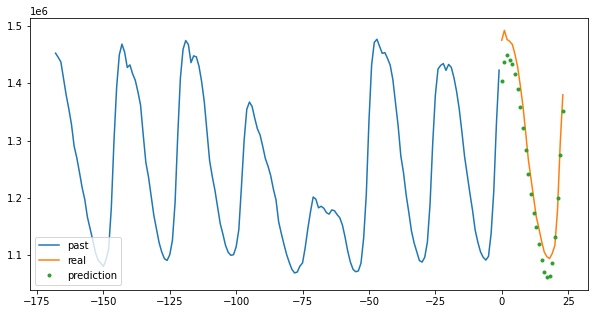

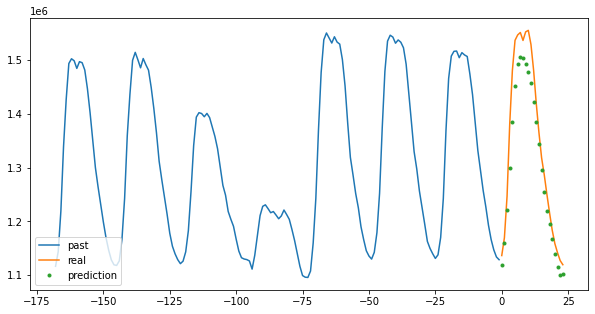

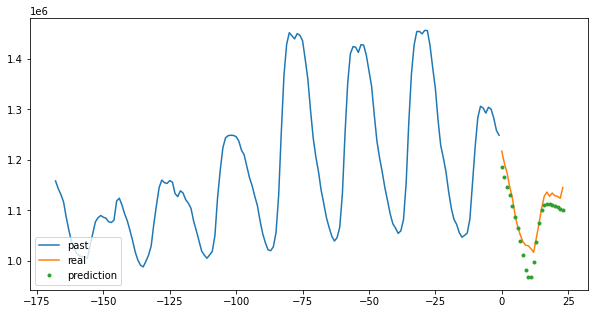

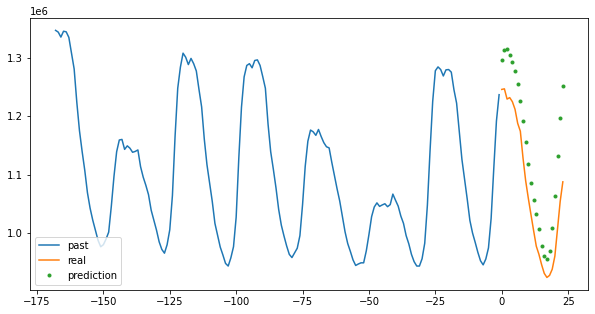

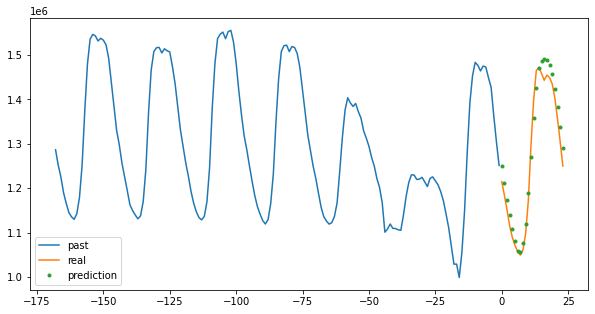

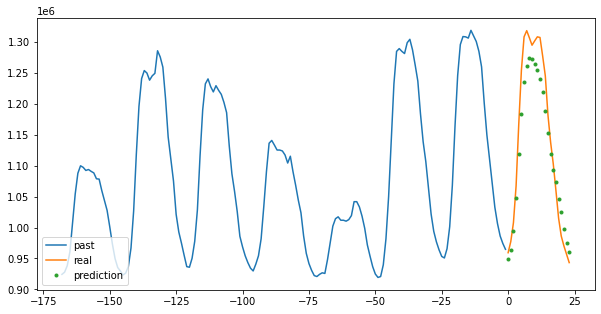

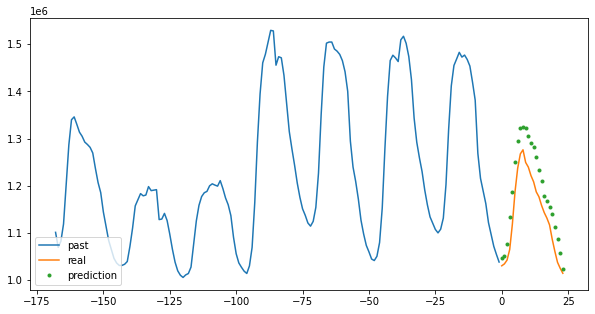

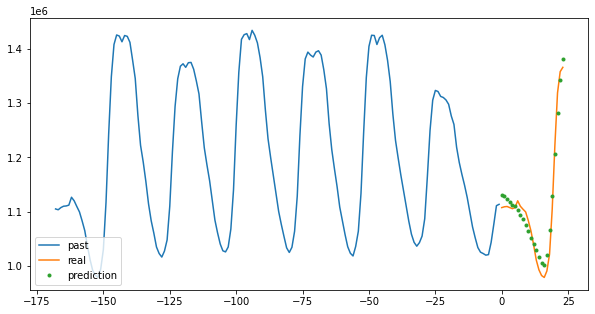

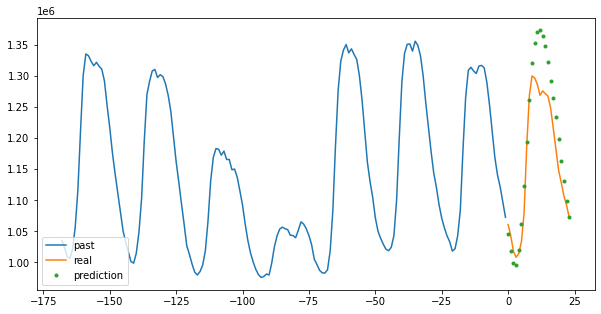

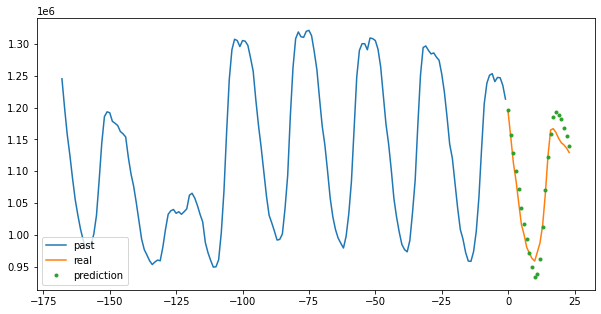

In [ ]:
for _ in range(10):
  example = test_dataset[np.random.randint(len(test_dataset))]
  plot_past_future(*example)

Graficamos todas las predicciones en el conjunto de datos de validación para observar el comportamiento general del modelo

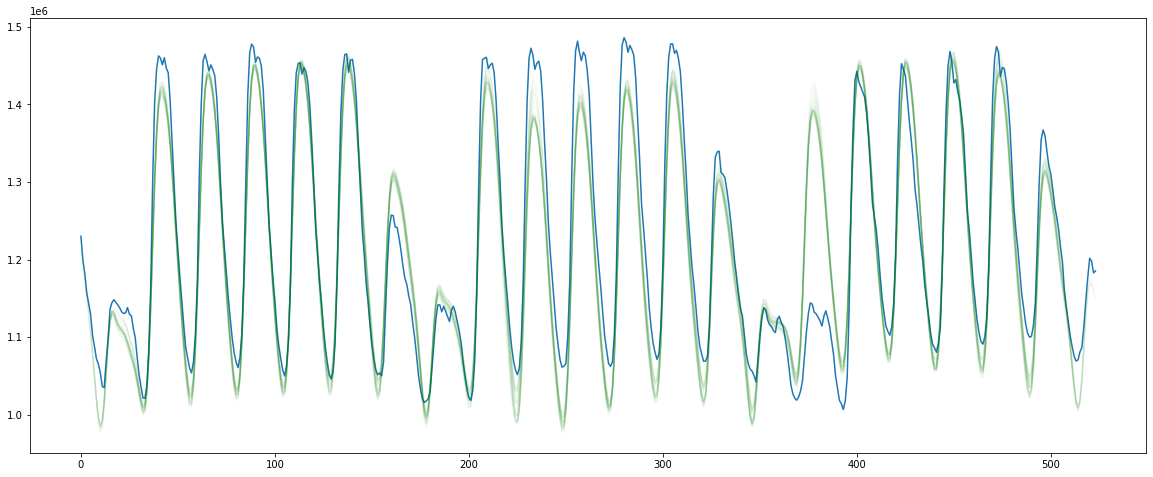

Validation MAE: 44347.02766728909
Validation MAPE: 0.036097833559880714


In [ ]:
total_mae = 0
total_mape = 0

n = 500
# n = len(test_dataset)
plt.figure(figsize=(20, 8))
plt.plot(test_data.to_numpy()[:n + horizon, 0])

for i, (inpt, target) in enumerate(tqdm(test_loader)):
  if i > n:
    break
  unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

  model.init_hidden(inpt.size(0))
  output = model(inpt.float()) 
  
  output_array = np.zeros((horizon, n_features))
  output_array[:, 0] = output.detach().numpy()
  unscaled_output = scaler.inverse_transform(output_array)[:, 0]

  real_future = np.zeros((horizon, n_features))
  real_future[:, 0] = target
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.plot(np.arange(i, i + horizon), unscaled_output, alpha=0.04, color='green')

  mae = np.absolute(unscaled_output - unscaled_future)
  mae = np.sum(mae)
  total_mae += mae

  mape = np.absolute((unscaled_output - unscaled_future) / unscaled_future)
  mape = np.sum(mape)
  total_mape += mape

plt.show()

total_mae /= n * horizon
total_mape /= n * horizon

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)

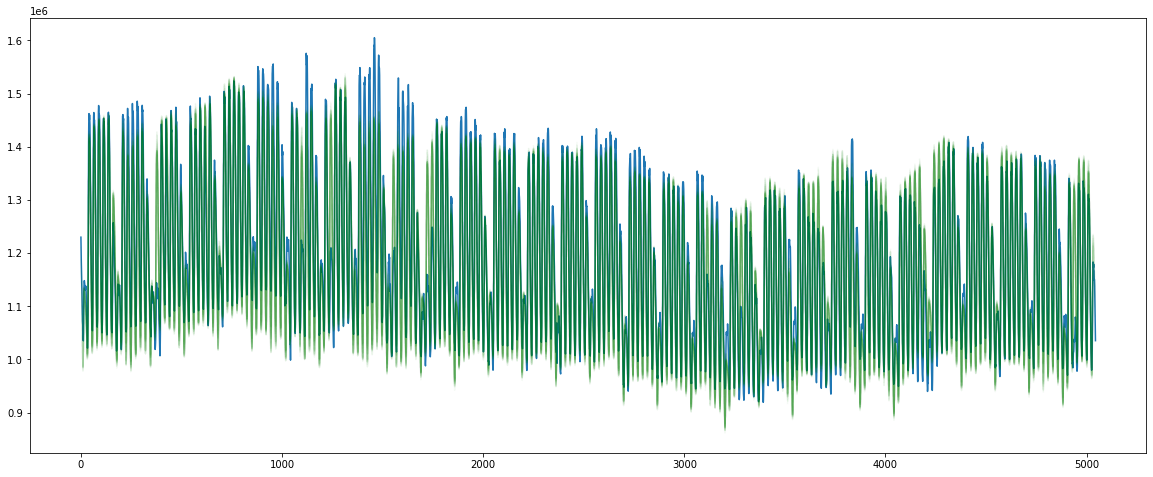

Validation MAE: 33207.52539148961
Validation MAPE: 0.027508395350618595


In [ ]:
total_mae = 0
total_mape = 0

# n = 500
n = len(test_dataset)
plt.figure(figsize=(20, 8))
plt.plot(test_data.to_numpy()[:n + horizon, 0])

for i, (inpt, target) in enumerate(tqdm(test_loader)):
  if i > n:
    break
  unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

  model.init_hidden(inpt.size(0))
  output = model(inpt.float()) 
  
  output_array = np.zeros((horizon, n_features))
  output_array[:, 0] = output.detach().numpy()
  unscaled_output = scaler.inverse_transform(output_array)[:, 0]

  real_future = np.zeros((horizon, n_features))
  real_future[:, 0] = target
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.plot(np.arange(i, i + horizon), unscaled_output, alpha=0.04, color='green')

  mae = np.absolute(unscaled_output - unscaled_future)
  mae = np.sum(mae)
  total_mae += mae

  mape = np.absolute((unscaled_output - unscaled_future) / unscaled_future)
  mape = np.sum(mape)
  total_mape += mape

plt.show()

total_mae /= n * horizon
total_mape /= n * horizon

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)

## Transferencia de aprendizaje para el comportamiento posterior al inicio de la cuarentena

No contamos con muchos datos sobre el consumo de energía durante la cuarentena, por lo tanto no es factible entrenar un modelo directamente con estos datos.

A la vez, el cambio en la dinámica previo y durante la cuarentena es muy drástico y un modelo entrenado con todos los datos muy probablemente tendría problemas para ajustarse correctamente.

Por ello optamos por aplicar transferencia de aprendizaje. Esta técnica consta de partir de un modelo entrenado en una tarea y ajustarlo a una tarea distinta pero lo suficientemente similar para esperar que el modelo pueda generalizar correctamente. De esta forma podemos aprovechar todos los datos.

In [ ]:
print('Data before COVID-19:', len(data_bc), sep='\t')
print('Data after COVID-19:', len(data_ac), sep='\t')

Data before COVID-19:	26064
Data after COVID-19:	5872


Normalizamos los datos con el mismo escalador

In [ ]:
# Usar el mismo escalador
data_ac_normalized = scaler.transform(data_ac)

In [ ]:
def train_model(model, train_loader, epochs=3, lr=0.00001):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.train(True)

  for i in range(epochs):
    print('Epoch:', i + 1)

    # Train
    print('Train')
    for inpt, target in tqdm(train_loader):
      model.init_hidden(inpt.size(0))
      output = model(inpt.float()) 
      loss = loss_function(output, target.float())
      loss.backward()
      optimizer.step()  
      optimizer.zero_grad() 
    print('Train loss :', loss.item())
    print()
  model.train(False)

  return loss_function

In [ ]:
def eval_model(model, test_loader, loss_function, scaler):
  agg_preds = np.empty(len(test_loader))
  print(len(test_loader))
  preds = []
  futures = []

  running_loss = 0

  for i, (inpt, target) in enumerate(tqdm(test_loader)):
    unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

    model.init_hidden(inpt.size(0))
    output = model(inpt.float())
    running_loss += loss_function(output, target.float()).item()
    
    output_array = np.zeros((horizon, n_features))
    output_array[:, 0] = output.detach().numpy()
    unscaled_output = scaler.inverse_transform(output_array)[:, 0]

    real_future = np.zeros((horizon, n_features))
    real_future[:, 0] = target
    unscaled_future = scaler.inverse_transform(real_future)[:, 0]

    preds.append(unscaled_output)
    futures.append(unscaled_future)
  
  print('Test loss :', running_loss / len(test_loader))

  return preds, futures
    

Una forma de evaluar el poder de generalización del modelo es utilizando validación cruzada.

Para series de tiempo la validación cruzada consiste en dividir los datos en $k$ dobleces. Se parte de un determinado número de dobleces iniciales para entrenar a un modelo y se evalúa en el doblez siguiente. En cada iteración posterior se agrega un nuevo doblez para el entrenamiento y nuevamente se valida en el doblez siguiente.

Al final todos los resultados de validación son agregados.

In [ ]:
k_folds = 10
start_folds = 2
cv_preds = dict()
n_transfer_data = len(data_ac_normalized)
n_fold_data = n_transfer_data // k_folds


for i in range(start_folds, k_folds):
  print(list(range(i)), i)
  n_train_data = i * n_fold_data
  train_data = data_ac_normalized[:n_train_data]
  test_data = data_ac_normalized[n_train_data:n_train_data + n_fold_data]

  train_dataset = TimeseriesDataset(train_data, train_data[:, 0], window, horizon)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TimeseriesDataset(test_data, test_data[:, 0], window, horizon)
  test_loader = torch.utils.data.DataLoader(test_dataset)

  # Clonar modelo base
  model_i = LSTM(n_features, n_hidden, n_layers)
  model_i.load_state_dict(model.state_dict())

  loss_function = train_model(model_i, train_loader)
  preds, futures = eval_model(model_i, test_loader, loss_function, scaler)
  cv_preds[i] = (preds, futures)


[0, 1] 2
Epoch: 1
Train



Train loss : 0.0075028399005532265

Epoch: 2
Train



Train loss : 0.004409461282193661

Epoch: 3
Train



Train loss : 0.0019069463014602661

395



Test loss : 0.002970469839755988
[0, 1, 2] 3
Epoch: 1
Train



Train loss : 0.003758493810892105

Epoch: 2
Train



Train loss : 0.0014469317393377423

Epoch: 3
Train



Train loss : 0.0007806469802744687

395



Test loss : 0.0045636374179179534
[0, 1, 2, 3] 4
Epoch: 1
Train



Train loss : 0.0032146302983164787

Epoch: 2
Train



Train loss : 0.003418970387428999

Epoch: 3
Train



Train loss : 0.002671564929187298

395



Test loss : 0.0030259725795410385
[0, 1, 2, 3, 4] 5
Epoch: 1
Train



Train loss : 0.0018859878182411194

Epoch: 2
Train



Train loss : 0.0014443261316046119

Epoch: 3
Train



Train loss : 0.0027020310517400503

395



Test loss : 0.003474546628090541
[0, 1, 2, 3, 4, 5] 6
Epoch: 1
Train



Train loss : 0.0013141195522621274

Epoch: 2
Train



Train loss : 0.001961064524948597

Epoch: 3
Train



Train loss : 0.0016662745038047433

395



Test loss : 0.002849658489112353
[0, 1, 2, 3, 4, 5, 6] 7
Epoch: 1
Train



Train loss : 0.0032279861625283957

Epoch: 2
Train



Train loss : 0.002319647464901209

Epoch: 3
Train



Train loss : 0.0019807182252407074

395



Test loss : 0.002515029947456161
[0, 1, 2, 3, 4, 5, 6, 7] 8
Epoch: 1
Train



Train loss : 0.0017172275111079216

Epoch: 2
Train



Train loss : 0.0011367031838744879

Epoch: 3
Train



Train loss : 0.001318343449383974

395



Test loss : 0.003976336972275159
[0, 1, 2, 3, 4, 5, 6, 7, 8] 9
Epoch: 1
Train



Train loss : 0.0019578631035983562

Epoch: 2
Train



Train loss : 0.001161296502687037

Epoch: 3
Train



Train loss : 0.0012678169878199697

395



Test loss : 0.003012385619163242


Analizando el error en cada doblez podemos darnos una idea de qué tan dependiente es el modelo al número de datos disponibles de entrenamiento.

Podemos esperar que conforme se agregan más dobleces el error de validación disminuirá. A la vez, si hay más cambios en el comportamiento veremos que el error aumente.

Validation MAE upto fold 2: 32270.665460987006
Validation MAPE upto fold 2: 0.02937797710458119

Validation MAE upto fold 3: 35310.00063356174
Validation MAPE upto fold 3: 0.03354562143719316

Validation MAE upto fold 4: 34518.81773348632
Validation MAPE upto fold 4: 0.03326426171854069

Validation MAE upto fold 5: 34003.66574362315
Validation MAPE upto fold 5: 0.03265601561956902

Validation MAE upto fold 6: 33192.001706996685
Validation MAPE upto fold 6: 0.031676465119840035

Validation MAE upto fold 7: 32531.311355832167
Validation MAPE upto fold 7: 0.030783940755323827

Validation MAE upto fold 8: 33134.134049673914
Validation MAPE upto fold 8: 0.0313682026810764

Validation MAE upto fold 9: 32692.031474609717
Validation MAPE upto fold 9: 0.030754949367785035

Validation MAE: 32692.031474609717
Validation MAPE: 0.030754949367785035


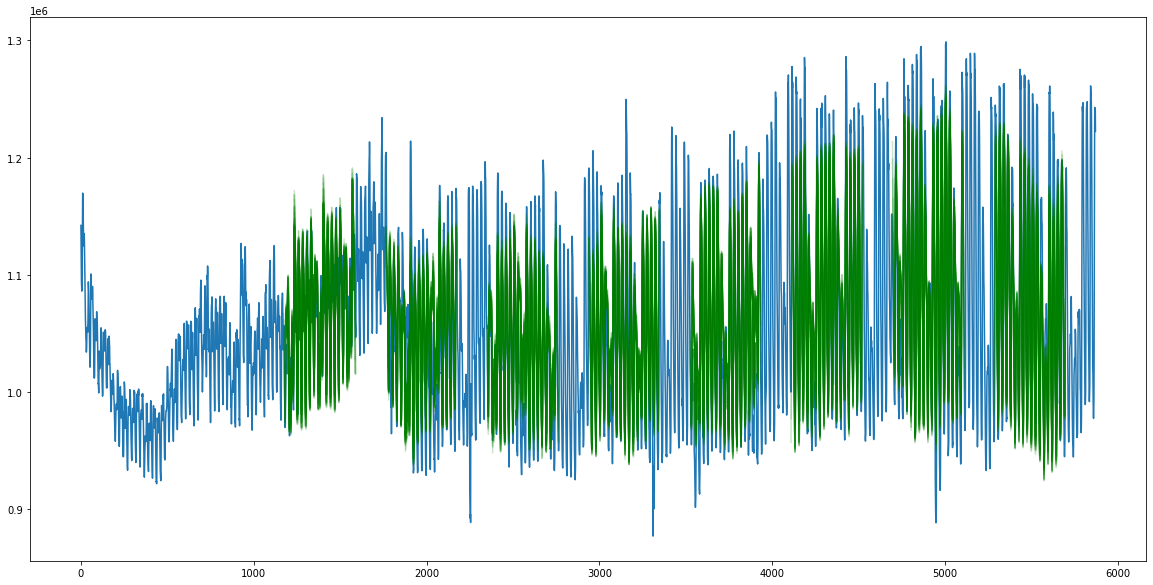

In [ ]:
n = 0
total_mae = 0
total_mape = 0

plt.figure(figsize=(20, 10))
plt.plot(data_ac.to_numpy()[:,0])

start_preds = start_folds * n_fold_data
for fold, (preds, futures) in cv_preds.items():
  for i, (pred, future) in enumerate(zip(preds, futures)):
    start_range = start_preds + (fold - start_folds) * n_fold_data
    x = np.arange(start_range + i, start_range + i + horizon)
    plt.plot(x, pred, alpha=0.2, color='green')

    mae = np.absolute(pred - future)
    mae = np.sum(mae)
    total_mae += mae

    mape = np.absolute((pred - future) / future)
    mape = np.sum(mape)
    total_mape += mape

    n += len(pred)

  print(f'Validation MAE upto fold {fold}:', total_mae / n)
  print(f'Validation MAPE upto fold {fold}:', total_mape / n)
  print()
  
total_mae /= n
total_mape /= n

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)